# You Only Look Once (YOLO)

# Importing Resources

We will start by loading the required packages into Python. We will be using *OpenCV* to load our images, *matplotlib* to plot them, a`utils` module that contains some helper functions to deal with Intersection Over Union and Non Max Suppression, and a modified version of *Darknet*. YOLO uses <a href="https://pjreddie.com/darknet/">Darknet</a> , an open source, deep neural network framework written by the creators of YOLO. The version of *Darknet* used in this notebook has been modified to work in PyTorch 0.4 and has been simplified because we won't be doing any training. Instead, we will be using a set of pre-trained weights that were trained on the [Common Objects in Context (COCO) database](http://cocodataset.org/#explore).

In [13]:
import cv2
import matplotlib.pyplot as plt

from utils import *
from darknet import Darknet

# Setting Up The Neural Network

We will be using the latest version of YOLO, known as YOLOv3. We have already downloaded the `yolov3.cfg` file that contains the network architecture used by YOLOv3 and placed it in the `/cfg/` folder. Similarly, we have placed the `yolov3.weights` file that contains the pre-trained weights in the `/weights/` directory. Finally, the `/data/` directory, contains the `coco.names` file that has the list of the 80 object classes that the weights were trained to detect.

In the code below, we start by specifying the location of the files that contain the neural network architecture, the pre-trained weights, and the object classes.  We then use *Darknet* to setup the neural network using the network architecture specified in the `cfg_file`. We then use the`.load_weights()` method to load our set of pre-trained weights into the model. Finally, we use the `load_class_names()` function, from the `utils` module, to load the 80 object classes.

In [15]:
# Set the location and name of the cfg file
cfg_file = './cfg/yolov3.cfg'

# Set the location and name of the pre-trained weights file
weight_file = './weights/yolov3.weights'

# Set the location and name of the COCO object classes file
namesfile = 'data/coco.names'

# Load the network architecture
darknet = Darknet(cfg_file)

# Load the pre-trained weights
darknet.load_weights(weight_file)

# Load the COCO object classes
class_names = load_class_names(namesfile)

# Taking a Look at The Neural Network

We can print the network using the `.print_network()` function.

In [16]:
# Print the neural network used in YOLOv3
darknet.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 1

As we can see, the neural network used by YOLOv3 consists mainly of convolutional layers, with some shortcut connections and upsample layers. For a full description of this network please refer to the <a href="https://pjreddie.com/media/files/papers/YOLOv3.pdf">YOLOv3 Paper</a>.

# Loading and Resizing Our Images

As we can see in the previous cell, the input size of the first layer of the network is 416 x 416 x 3. Since images have different sizes, we have to resize our images to be compatible with the input size of the first layer in the network.  

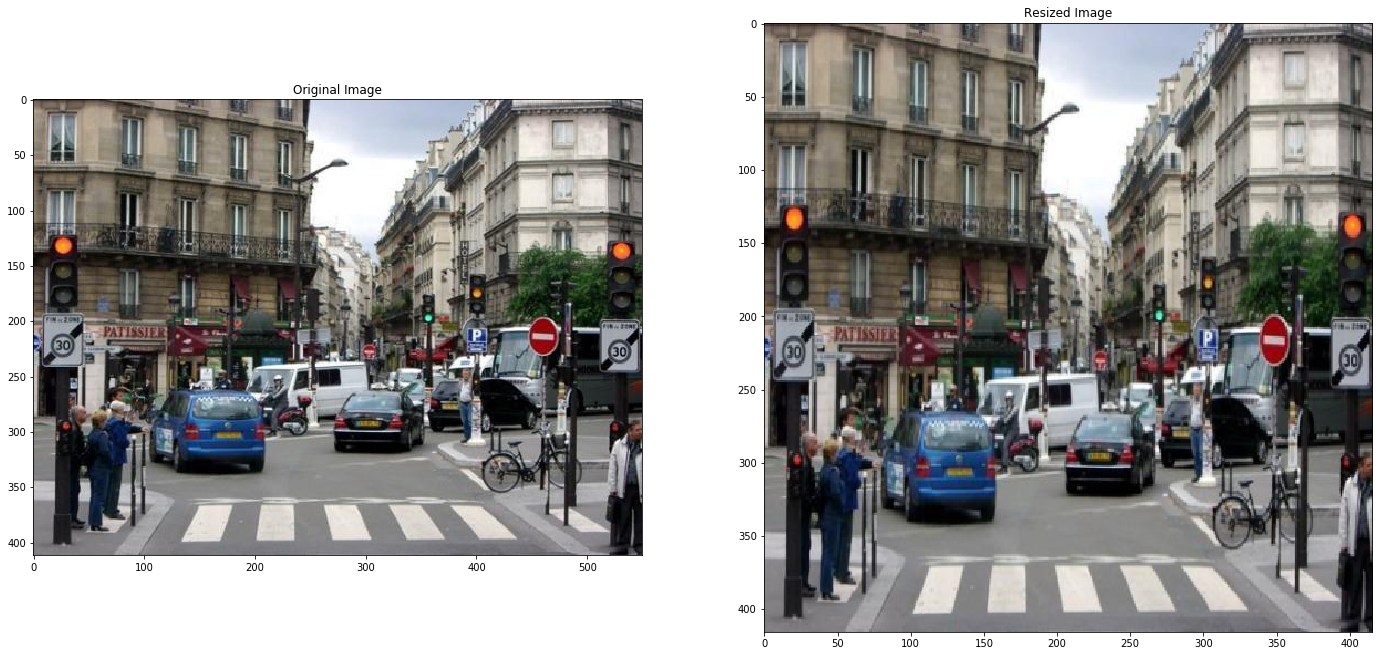

In [17]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Load the image
img = cv2.imread('./images/paris.jpg')

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (darknet.width, darknet.height))

# Display the images
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

# Setting the Non-Maximal Suppression Threshold

YOLO uses **Non-Maximal Suppression (NMS)** to only keep the best bounding box. The first step in NMS is to remove all the predicted bounding boxes that have a detection probability that is less than a given NMS threshold.  

In [10]:
# Set the NMS threshold
nms_thresh = 0.6

# Setting the Intersection Over Union Threshold

After removing all the predicted bounding boxes that have a low detection probability, the second step in NMS, is to select the bounding boxes with the highest detection probability and eliminate all the bounding boxes whose **Intersection Over Union (IOU)** value is higher than a given IOU threshold. 

In [11]:
# Set the IOU threshold
iou_thresh = 0.4

# Object Detection

We detect the objects using the `detect_objects(m, resized_image, iou_thresh, nms_thresh)`function from the `utils` module. 

Each bounding box contains 7 parameters: the coordinates *(x, y)* of the center of the bounding box, the width *w* and height *h* of the bounding box, the confidence detection level, the object class probability, and the object class id. The `detect_objects()` function also prints out the time it took for the YOLO algorithm to detect the objects in the image and the number of objects detected. (Here we are running on CPU)

Once we have the bounding boxes of the objects found by YOLO, we can print the class of the objects found and their corresponding object class probability. To do this we use the `print_objects()` function in the `utils` module.

Finally, we use the `plot_boxes()` function to plot the bounding boxes and corresponding object class labels found by YOLO in our image. 



It took 3.289 seconds to detect the objects in the image.

Number of Objects Detected: 14 

Objects Found and Confidence Level:

1. car: 1.000000
2. car: 0.999933
3. traffic light: 1.000000
4. traffic light: 1.000000
5. person: 0.999967
6. bicycle: 1.000000
7. truck: 0.984888
8. traffic light: 1.000000
9. person: 0.999995
10. motorbike: 0.999958
11. person: 0.999991
12. person: 1.000000
13. car: 0.998999
14. traffic light: 1.000000


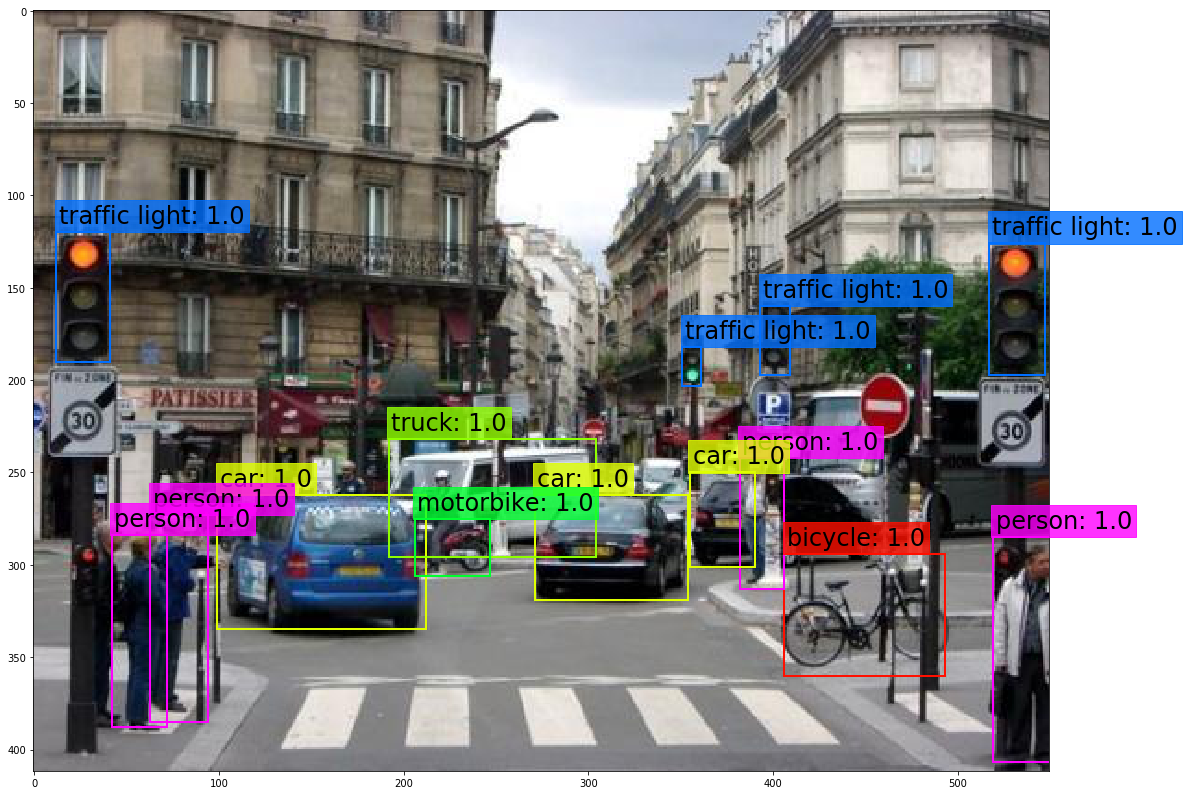

In [18]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Load the image
img = cv2.imread('./images/paris.jpg')

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (darknet.width, darknet.height))

# Set the IOU threshold. Default value is 0.4
iou_thresh = 0.4

# Set the NMS threshold. Default value is 0.6
nms_thresh = 0.6

# Detect objects in the image
boxes = detect_objects(darknet, resized_image, iou_thresh, nms_thresh)

# Print the objects found and the confidence level
print_objects(boxes, class_names)

#Plot the image with bounding boxes and corresponding object class labels
plot_boxes(original_image, boxes, class_names, plot_labels = True)